In [1]:
import socket
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import time
import struct
import math

# Setup basic information

In [2]:
# port that the simulation is listening on
request_port = 9000
receive_port = 9001

# ip address of the simulation
client_ip = "172.25.183.58"
self_ip = "172.25.183.58"

# Test teleport movement

In [21]:
x_distance = 0
z_distance = 1
dtheta_y = 0

#tag for teleport movement requests is 'TLPT'
tag = 'TLPT'
# the format for the teleport movement request is
# [(4 char)tag, (float)x_distance, (float)z_distance, (float)dtheta_y]
#where x_distance and z_distance are in meters in body frame and theta_y is rotation in degrees around the y-axis
payload = bytearray()
payload.extend( tag.encode() )
payload.extend( struct.pack("f", x_distance) )
payload.extend( struct.pack("f", z_distance) )
payload.extend( struct.pack("f", dtheta_y) )

pos_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
pos_socket.sendto( payload, (client_ip, request_port) )
pos_socket.close()

# Test force movement

In [22]:
z_force = 0
y_torque = 10

#tag for force movement is 'xBFF'
tag = 'xBFF'
# the format for the force movement request is
# [(4 char)tag, (float)z_force, (float)y_torque]
#where z_force is in units? and will be applied to the z axis in body frame 
#and y_torque is in units? and will be applied around the y axis in body frame
payload = bytearray()
payload.extend( tag.encode() )
payload.extend( struct.pack("f", z_force) )
payload.extend( struct.pack("f", y_torque) )

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()

# Test Image Requests without Metadata

<TESSE Agent Metadata v0.1>
  <position x='-12.25508/' y='2.362137' z='25.41617'/>
  <quaternion x='0/' y='0.9256136' z='0' w='0.37847'/>
  <velocity x_dot='0/' y_dot='-0.002464981' z_dot='0'/>
  <angular velocity x_ang_dot='0/' y_ang_dot='0.369029' z_ang_dot ='0'/>
  <acceleration x_ddot='0/' y_ddot='-0.4141233' z_ddot='0'/>
  <angular acceleration x_ang_ddot='0/' y_ang_ddot='-18.8357' z_ang_ddot='0'/>
  <time>22.59701</time>
  <collision status='false' name=''/>
</TESSE Agent Metadata v0.1>



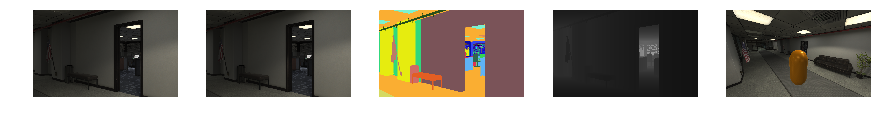

In [23]:
# setup tcp listener - images will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)


#image request without metadata tag is rIMG
#tag = 'rIMG' 
#image request with metadata tag is tIMG
tag = 'tIMG'
# the message format is as follows
#[(4 char)tag, (int32) camera_index 1, (int32)compressed, (int32)single channel]
#[(4 char)tag, (int32) camera_index 2, (int32)compressed, (int32)single channel]
#etc. for each camera requested
# compressed is a flag to received compressed images (1 for compressed), 
#'single channel' is a flag to receive only one channel images (1 for single channel),
#currently you can request compressed OR single channel, but not single channel, compressed images
# Camera indexes are currently as follows: 
# 0: rgb left
# 1: rgb right
# 2: segmentation
# 3: depth
# 4: third person
payload = bytearray()
payload.extend( tag.encode() )
payload.extend( bytearray(struct.pack('I', 0)) ) # first image camera id 
payload.extend( bytearray(struct.pack('I', 0)) ) # first image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # first image single channel flag
payload.extend( bytearray(struct.pack('I', 1)) ) # second image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # second image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # second image single channel flag
payload.extend( bytearray(struct.pack('I', 2)) ) # third image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # third image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # third image single channel flag
payload.extend( bytearray(struct.pack('I', 3)) ) # fourth image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # fourth image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # fourth image single channel flag
payload.extend( bytearray(struct.pack('I', 4)) ) # fifth image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # fifth image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # fifth image single channel flag


# send request to simulation
request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()

"""
response will come back from Unity as a byte array containing the following
[multi image payload header][img 1 header][img 1 payload][img 2 header][img 2 payload]...[img N header][img N payload][bounding_box_metadata][image bounds metadata]

[multi image payload header] = 8 bytes, ["mult"(byte[4]), total payload length(uint32)]
[img header] = 32 bytes, ["uImG"(byte[4]), image payload length(uint32), image width(uint32), image height(uint32), camera id(uint32), image_type(byte[4]),0(uint32),0(uint32)]
[img payload] = byte array of image data
"""

# get the information
#try:
# first, get the image header info
payload_header_size = 12
img_header_size = 32
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

#print(len(data))
# ensure this is a valid tag
tag = data[0:4].decode("utf-8")
#print("got tag " + tag)
payload_length_imgs = struct.unpack("I",data[4:8])[0]
payload_length_meta = struct.unpack("I",data[8:12])[0]

#print("payload length images {}".format(payload_length_imgs))
#print("payload length metadata {}".format(payload_length_meta))

imgs = []
cam_ids = []
try:
    if( tag == "mult" ):
        total_data_received = 0

        while( total_data_received < payload_length_imgs ):
            # get the header payload
            #print("fetching data...")
            data = conn.recv( img_header_size )
            total_data_received += len(data)
            if( data[0:4].decode("utf-8") == "uImG" ):
                # get the rest of the image metadata
                img_payload_length = struct.unpack("I",data[4:8])[0]
                img_width = struct.unpack("I",data[8:12])[0]
                img_height = struct.unpack("I",data[12:16])[0]
                cam_id = struct.unpack("I",data[16:20])[0]
                img_type = data[20:24].decode("utf-8")

            img_payload = bytearray()
            while( len(img_payload) < img_payload_length ):
                img_payload.extend( conn.recv(img_payload_length - len(img_payload)) )

            total_data_received += len(img_payload)

            if( img_type == 'xRGB' ):
                img = np.flip(np.ndarray((img_height,img_width,3),buffer=img_payload,dtype='uint8'),0)
            elif( img_type == 'xGRY' ):
                img = np.flip(np.ndarray((img_height,img_width),buffer=img_payload,dtype='uint8'),0)
            elif( img_type == 'cRGB'):
                ndarr = np.frombuffer(img_payload, dtype=np.uint8)
                img = cv2.imdecode(ndarr, cv2.IMREAD_UNCHANGED)
                img = img[:,:,[2,1,0]]

            imgs.append(img)
            cam_ids.append(cam_id)

        meta_payload = bytearray()
        if( total_data_received > payload_length_imgs ):
            print("already got the metadata, just need to extract it")
            if( total_data_received == (payload_length_imgs + payload_length_meta) ):
                meta_payload = img_payload[img_payload_length:]
            elif( total_data_received < (payload_length_imgs + payload_length_meta) ):
                print("need to get the rest of the metadata")
                data = conn.recv( (payload_length_imgs + payload_length_meta) - total_data_received )
                meta_payload = img_payload[img_payload_length:]
                meta_payload.extend(data)
        elif( total_data_received == payload_length_imgs ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)


        #print( "{},{}".format(img_width,img_height) )
        print(meta_payload.decode("utf-8"))
        conn.close()
except:
    print("failed!")
    receive_socket.close()
    conn.close()
    
    
receive_socket.close()
if( len(imgs) > 1 ):
    fig, ax = plt.subplots(1,len(imgs),figsize=(15,10))
    for i in range(len(imgs)):
        ax[i].axis('off')
        ax[i].imshow(imgs[i])
else:
    plt.imshow(imgs[0])
    plt.axis('off')

plt.show()
    


# Test Metadata Requests

In [18]:
# setup tcp listener - metadata will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)

#tag for metadata request is 'rMET'
tag = 'rMET'
# the format for the force movement request is
# [(4 char)tag]

payload = bytearray()
payload.extend( tag.encode() )

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()

# listen for response on tcp socket
payload_header_size = 8
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

try:
    # process header information
    tag = data[0:4].decode("utf-8")
    payload_length_meta = struct.unpack("I",data[4:8])[0]
    if( tag == "meta" ):
        # process metadata payload
        meta_payload = bytearray()
        if( total_data_received > payload_length_imgs ):
            print("already got the metadata, just need to extract it")
            if( total_data_received == (payload_length_imgs + payload_length_meta) ):
                meta_payload = img_payload[img_payload_length:]
            elif( total_data_received < (payload_length_imgs + payload_length_meta) ):
                print("need to get the rest of the metadata")
                data = conn.recv( (payload_length_imgs + payload_length_meta) - total_data_received )
                meta_payload = img_payload[img_payload_length:]
                meta_payload.extend(data)
        elif( total_data_received == payload_length_imgs ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)
except:
    print("failed!")
    receive_socket.close()
    conn.close()

print(meta_payload.decode("utf-8"))
conn.close()

receive_socket.close()

<TESSE Agent Metadata v0.1>
  <position x='-10.17819/' y='2.349351' z='29.19039'/>
  <quaternion x='0/' y='0.7092755' z='0' w='0.7049314'/>
  <velocity x_dot='-0.1011973/' y_dot='4.161894E-05' z_dot='0.002138931'/>
  <angular velocity x_ang_dot='0/' y_ang_dot='-0.001330546' z_ang_dot ='0'/>
  <acceleration x_ddot='5.165236/' y_ddot='-0.4120685' z_ddot='-0.1091737'/>
  <angular acceleration x_ang_ddot='0/' y_ang_ddot='0.06791268' z_ang_ddot='0'/>
  <time>48.13597</time>
  <collision status='false' name=''/>
</TESSE Agent Metadata v0.1>

